In [1]:
import os
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
data_dir = "../dataset-original"

In [6]:
img_height, img_width = 160, 160
batch_size = 64

# To Reproduce result
tf.random.set_seed(42)
np.random.seed(42)

# Why 42?
# "Answer to the Ultimate Question of Life" from The Hitchhiker's Guide to the Galaxy

num_epochs = 250

In [7]:
ImageDataGenerator?

Init signature:
ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode='nearest',
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0,
    interpolation_order=1,
    dtype=None,
)
Docstring:     
Generate batches of tensor image data with real-time data augmentation.

Deprecated: `tf.keras.preprocessing.image.ImageDataGenerator` is not
recommended for new code. Prefer loading images with
`tf.keras.utils.image_dataset_from_directory` and transforming the output
`tf.data.Dataset` with preprocessing layers. For more information, see the
tutoria

### Preprocessing

    Rescale: Normalize pixel values to the range [0, 1] to aid model convergence

### Augmentation

    1) Shear Range: Introduce deformations up to 20 degrees to introduce deformations for robustness such as shaky pictures.
    
    2) Zoom Range: Randomly zoom in/out by 20% to simulate varying object scales in images.
       
    3) Horizontal Flip: Enable random horizontal flipping for different camera angle variations.
       
    4) Rotation Range: Rotate images up to 40 degrees to mimic real world camera angle variations. 
    
    5) Width Shift Range: Shift images horizontally to mimic real world camera angle variations.  
    
    6) Height Shift Range: Shift images vertically to mimic real world camera angle variations.  
    
    7) Brightness Range: Adjust brightness between 0.5 and 1.5 times to adapt to diverse lighting conditions.  
    
    8) Channel Shift Range: Shift color channels to introduce color variations for robustness (different camera specification such as RGB vs SRGB.

In [8]:
#The reason for rescaling is to converge to a satisfactory solution using reasonable time and resource.

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,          
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    channel_shift_range=20,
    validation_split=0.2
)

In [9]:
ImageDataGenerator.flow_from_directory?

Signature:
ImageDataGenerator.flow_from_directory(
    self,
    directory,
    target_size=(256, 256),
    color_mode='rgb',
    classes=None,
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=None,
    save_to_dir=None,
    save_prefix='',
    save_format='png',
    follow_links=False,
    subset=None,
    interpolation='nearest',
    keep_aspect_ratio=False,
)
Docstring:
Takes the path to a directory & generates batches of augmented data.

Args:
    directory: string, path to the target directory. It should contain
      one subdirectory per class. Any PNG, JPG, BMP, PPM or TIF images
      inside each of the subdirectories directory tree will be included
      in the generator. See [this script](
      https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d)
      for more details.
    target_size: Tuple of integers `(height, width)`, defaults to `(256,
      256)`. The dimensions to which all images found will be resized.
    color_mode: One of 

In [10]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    shuffle=True,
    class_mode='categorical',
    subset='training'
)

# Why categorical?
# Determines the type of label arrays that are returned:
#       - "categorical" will be 2D one-hot encoded labels

Found 2024 images belonging to 6 classes.


In [11]:
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    shuffle=True,
    class_mode='categorical',
    subset='validation'
)

Found 503 images belonging to 6 classes.


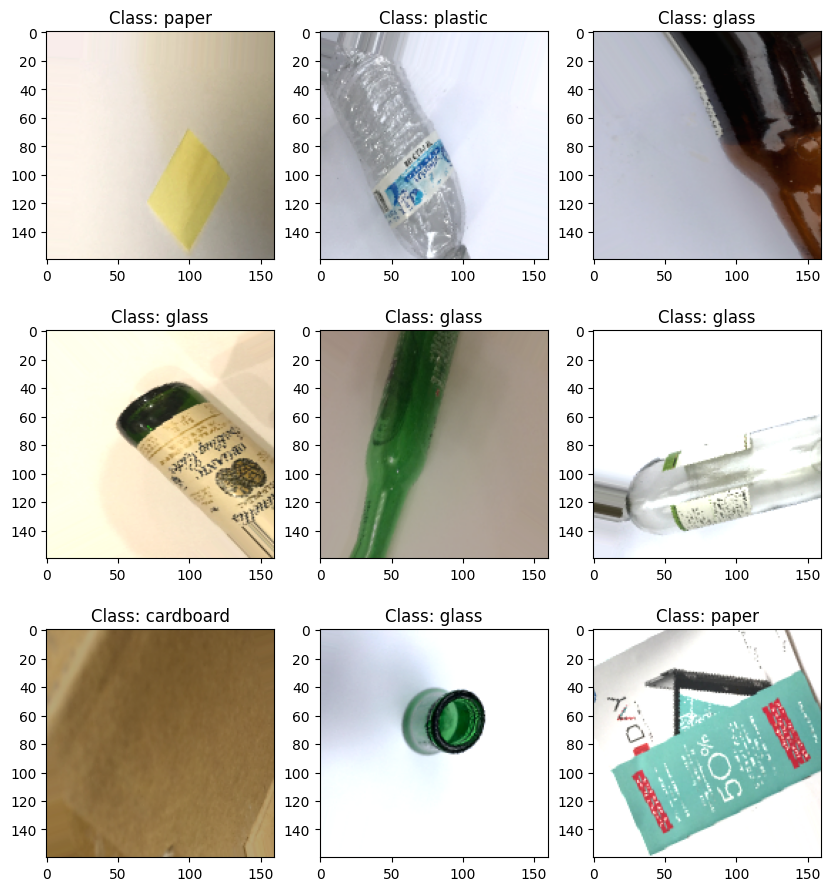

In [12]:
sample_images, sample_labels = next(train_generator)
class_names = list(train_generator.class_indices.keys())

fig, axs = plt.subplots(3, 3, figsize=(10, 11))

for i, ax in enumerate(axs.flat):
   ax.imshow(sample_images[i])
   class_index = np.argmax(sample_labels[i])
   class_name = class_names[class_index]  
   ax.set_title(f"Class: {class_name}")

plt.show()

In [13]:
from sklearn.utils.class_weight import compute_class_weight
class_labels = np.unique(train_generator.classes)
class_weights = compute_class_weight('balanced', classes=class_labels, y=train_generator.classes)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(class_weight_dict)

{0: 1.04437564499484, 1: 0.8412302576891105, 2: 1.0284552845528456, 3: 0.7086834733893558, 4: 0.8739205526770294, 5: 3.066666666666667}


####  Weightage during training

    1) Class 0 (Cardboard): Slightly up-weighted.  
    
    2) Class 1 (Glass): Down-weighted.  
    
    3) Class 2 (Metal): Slightly up-weighted.  
    
    4) Class 3 (Paper): Down-weighted.

    5) Class 4 (Plastic): Down-weighted.
    
    6) Class 5 (Trash): Significantly up-weighted.  

In [14]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [15]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = True

9406464/9406464 [==============================] - 2s 0us/step


In [16]:
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(len(train_generator.class_indices), activation='softmax')
])

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 6)                 1

In [18]:
checkpoint_dir = './mobilenet_a_checkpoints/'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_filepath = os.path.join(checkpoint_dir, 'model_checkpoint_{epoch:02d}.h5')

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

callbacks = [model_checkpoint_callback, early_stopping_callback]

In [19]:
history = model.fit(
    train_generator,
    epochs=250,
    steps_per_epoch=len(train_generator),
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    class_weight=class_weight_dict,
    callbacks=[model_checkpoint_callback, early_stopping_callback]
)

Epoch 1/250
64/64 [==============================] - ETA: 0s - loss: 1.9656 - accuracy: 0.2381
Epoch 1: val_accuracy improved from -inf to 0.34592, saving model to ./checkpoints\model_checkpoint_01.h5
64/64 [==============================] - 281s 4s/step - loss: 1.9656 - accuracy: 0.2381 - val_loss: 1.7298 - val_accuracy: 0.3459
Epoch 2/250
64/64 [==============================] - ETA: 0s - loss: 1.7972 - accuracy: 0.2747
Epoch 2: val_accuracy did not improve from 0.34592
64/64 [==============================] - 285s 4s/step - loss: 1.7972 - accuracy: 0.2747 - val_loss: 1.6826 - val_accuracy: 0.3439
Epoch 3/250
64/64 [==============================] - ETA: 0s - loss: 1.6761 - accuracy: 0.3246
Epoch 3: val_accuracy improved from 0.34592 to 0.38966, saving model to ./checkpoints\model_checkpoint_03.h5
64/64 [==============================] - 279s 4s/step - loss: 1.6761 - accuracy: 0.3246 - val_loss: 1.5846 - val_accuracy: 0.3897
Epoch 4/250
64/64 [==============================] - ETA: 0

In [12]:
history_file_path = 'mobile_net_a_training_history.pkl'

with open(history_file_path, 'wb') as file:
    pickle.dump(history.history, file)

print("Training history saved to:", history_file_path)

### Validation

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing import image

In [2]:
data_dir = "../dataset-original"

In [3]:
img_height, img_width = 160, 160
batch_size = 64
tf.random.set_seed(42)
np.random.seed(42)


validation_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=40,          
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    channel_shift_range=20,
    validation_split=0.2
)

validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    shuffle=False,
    class_mode='categorical',
    subset='validation'
)

Found 503 images belonging to 6 classes.


In [4]:
class_names = list(validation_generator.class_indices.keys())
class_names

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [5]:
best_model_location = './mobilenet_a_checkpoints/model_checkpoint_52.h5'
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = True
model = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(len(validation_generator.class_indices), activation='softmax')
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
model.load_weights(best_model_location)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 6)                 1

In [6]:
predictions = model.predict(validation_generator)

16/16 [==============================] - 60s 3s/step


In [7]:
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes

In [8]:
conf_matrix = confusion_matrix(true_classes, predicted_classes)

In [9]:
accuracy = accuracy_score(true_classes, predicted_classes)
print("Accuracy of the best model: {:.2f}%".format(accuracy * 100))

Accuracy of the best model: 78.33%


In [10]:
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 59   2   3  11   0   5]
 [  0  86   6   3   5   0]
 [  0  16  62   1   1   2]
 [  4   2   1 110   1   0]
 [  0  21   1  11  56   7]
 [  0   0   2   2   2  21]]


In [11]:
classification_scores = classification_report(true_classes, predicted_classes, target_names=validation_generator.class_indices.keys(), output_dict=True)
classification_scores_df = pd.DataFrame(classification_scores).transpose()
classification_scores_df

,precision,recall,f1-score,support
cardboard,0.936508,0.737500,0.825175,80.0000
glass,0.677165,0.860000,0.757709,100.0000
metal,0.826667,0.756098,0.789809,82.0000
paper,0.797101,0.932203,0.859375,118.0000
plastic,0.861538,0.583333,0.695652,96.0000
trash,0.600000,0.777778,0.677419,27.0000
accuracy,0.783300,0.783300,0.783300,0.7833
macro avg,0.783163,0.774485,0.767523,503.0000
weighted avg,0.801967,0.783300,0.781369,503.0000


1/1 [==============================] - 0s 15ms/step


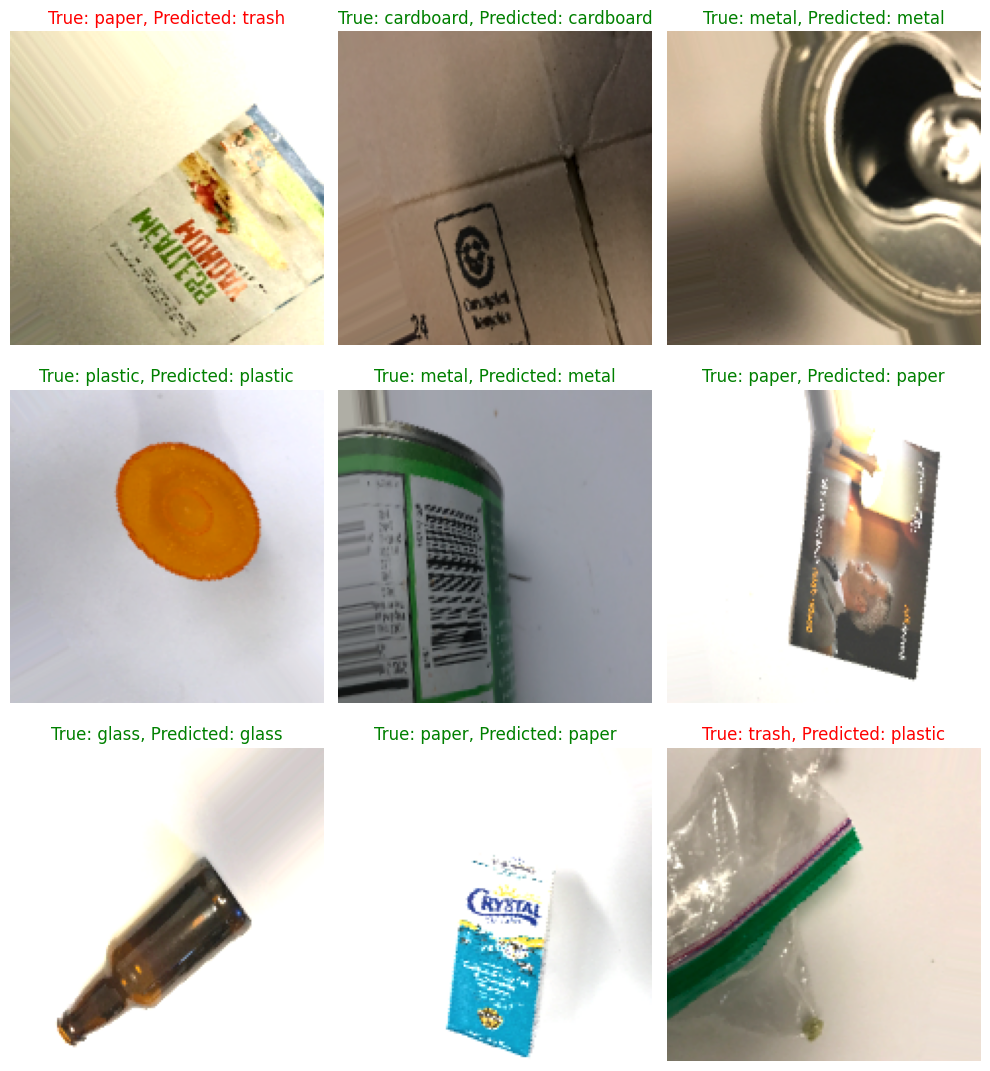

In [12]:
num_samples = 9
random_indices = np.random.choice(len(validation_generator), size=num_samples, replace=False)

sample_images = []
sample_labels = []

for idx in random_indices:
    batch = validation_generator[idx]
    image = batch[0][0]
    label_index = np.argmax(batch[1][0])
    sample_images.append(image)
    sample_labels.append(label_index)

class_names = list(validation_generator.class_indices.keys())

# Plot images with true and predicted labels
fig, axs = plt.subplots(3, 3, figsize=(10, 11))

for ax, image, true_label_index in zip(axs.flat, sample_images, sample_labels):
    true_label_name = class_names[true_label_index]
    predicted_label_probs = model.predict(np.expand_dims(image, axis=0))[0]
    predicted_label_index = np.argmax(predicted_label_probs)
    predicted_label_name = class_names[predicted_label_index]
    label_color = 'green' if predicted_label_index == true_label_index else 'red'
    
    ax.imshow(image)
    ax.set_title(f"True: {true_label_name}, Predicted: {predicted_label_name}", color=label_color)
    ax.axis('off')

plt.tight_layout()
plt.show()


### Real World Test

1/1 [==============================] - 0s 19ms/step


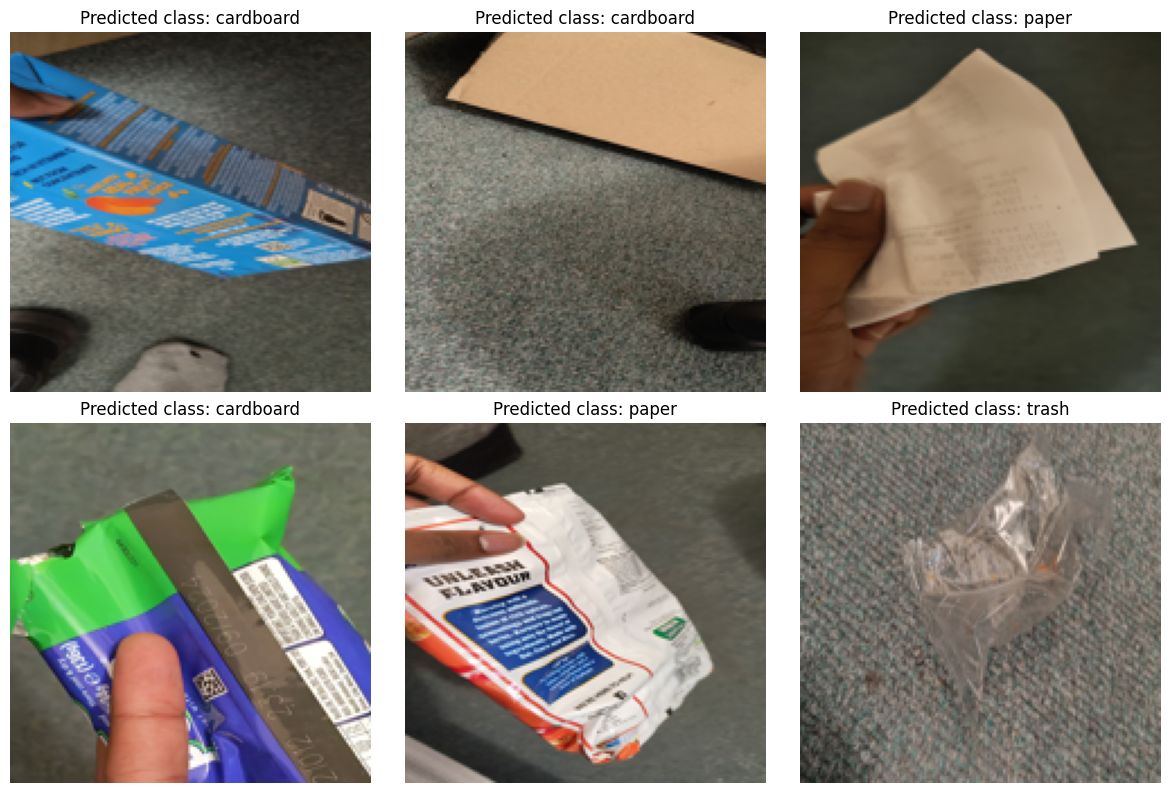

In [13]:
from PIL import Image
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

folder_path = '../live_samples/'

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

for i, filename in enumerate(os.listdir(folder_path)[:6]):
    if filename.endswith(".jpg") or filename.endswith(".jpeg"):
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path)
        img = img.resize((160, 160))
        img_array = np.array(img, dtype=np.float32)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.  # Normalize pixel values to [0, 1] as float32

        predictions = model.predict(img_array)

        predicted_class_index = np.argmax(predictions[0])
        predicted_class_name = class_names[predicted_class_index]

        ax = axs[i // 3, i % 3]
        ax.imshow(img)
        ax.set_title(f"Predicted class: {predicted_class_name}")
        ax.axis('off')

plt.tight_layout()
plt.show()